In [15]:
!python3 -m pip install blackcellmagic

  Using cached https://files.pythonhosted.org/packages/2b/dc/97c5936a65fe7c58d7cf474ea7488554905c04177e15df1fcab64332e48d/blackcellmagic-0.0.2.tar.gz
  Could not find a version that satisfies the requirement black (from blackcellmagic) (from versions: )
No matching distribution found for black (from blackcellmagic)


In [1]:
import os
import cv2 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
    Callback
)
from keras.datasets import mnist, fashion_mnist, cifar10, cifar100
from keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Dense,
    Input,
    MaxPooling2D,
    UpSampling2D,
)
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras.utils.training_utils import multi_gpu_model
from itertools import chain

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
np.random.seed(42)

In [3]:
ANOMALY_STR ="anomaly"
NORMAL_STR = "normal"
USE_CASE ="bottle"
img_path = os.path.join("imgs",USE_CASE)
if not os.path.isdir(img_path):
    os.mkdir(img_path)
ckpt_path = os.path.join("ckpts",USE_CASE)
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)
data_path = os.path.join("data","mvtec_anomaly_detection")
base_log_dir= os.path.join("logs",USE_CASE)

if not os.path.isdir(base_log_dir):
    os.mkdir(base_log_dir)


classes = list(filter(lambda d:os.path.isdir(os.path.join(data_path,d)),  os.listdir(data_path)))
classes

['tile',
 'pill',
 'grid',
 'toothbrush',
 'metal_nut',
 'carpet',
 'cable',
 'bottle',
 'zipper',
 'hazelnut',
 'wood',
 'capsule',
 'transistor',
 'leather',
 'screw']

# Preparing the data

In [4]:
object_categories = ["bottle","cable","capsule","metal_nut","pill","screw","tile","toothbrush","transistor","zipper"]

In [5]:
def read_image_file_names(dir_path):
    """Reads images per category for given directory path.
    Returns images as a generator object in intervall[0,1] rgb-format"""
    # data = np.empty(shape=(0,1,1,3),dtype=np.int8)
    cur_shape= None
    path_to_dir = os.path.join(os.getcwd(),dir_path)
    return [os.path.join(path_to_dir,p) for p in os.listdir(dir_path)]

In [6]:
def load_data():
    normal_path = os.path.join(data_path, USE_CASE, "train", "good")
    normal_train_data = read_image_file_names(normal_path)
    
    test_path = os.path.join(data_path,USE_CASE,"test")
    normal_test_data = read_image_file_names(os.path.join(test_path,"good"))
    anomaly_test_data = []
    for p in os.listdir(test_path):
        if p != "good":#    
            gen = read_image_file_names(os.path.join(test_path,p))
            anomaly_test_data +=  read_image_file_names(os.path.join(test_path,p))
    return normal_train_data, normal_test_data,normal_test_data, anomaly_test_data

In [7]:
X_normal_train, X_normal_validate, X_normal_test, X_anomaly_test = load_data()

In [8]:
def plot_mvtec(data):
    plt.imshow(data)

In [9]:
def hide_axis(subplt, x=True, y=True):
    if x:
        subplt.get_xaxis().set_visible(False)
    if y:
        subplt.get_yaxis().set_visible(False)

In [10]:
def yield_images(file_paths, batch_size,single_batch=False, input_only=False):
    # yields batch_size'd arrays of images, either indefinetly or only one batch for prediction case 
        while True:
            rands = np.random.randint(0,len(file_paths),batch_size)
            #print(rands)
            imgs = np.zeros((batch_size,900,900,3))
            for j,r in enumerate(rands):
                # print(r,len(file_paths))
                fp = file_paths[r]
                if os.path.isfile(fp):
                    img = cv2.imread(fp)   # reads an image in the BGR format
                    imgs[j] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # BGR -> RGB
            
                    
            if not input_only:
                yield imgs / 255, imgs/255
            else: 
                yield imgs /255
            if single_batch:
                break

In [11]:
def get_images(paths, n):
    # returns an array of images
    return next(yield_images(paths, n,single_batch=True,input_only=True))

In [12]:
def plot_samples(row_one, row_two, f_plot, outfile=""):
    """Plot 8 sample images of the row_one and row_two"""
    plt.figure(figsize=(16, 4))
    # row_one
    n = min([8])
    for i in range(n):
        try:
            ax = plt.subplot(2, n, i+1)
            hide_axis(ax)
            f_plot(row_one[i]) # row_one
        except IndexError:
            pass
        try:
            ax = plt.subplot(2, n, n+i+1)
            hide_axis(ax)
            f_plot(row_two[i]) # row_two
        except IndexError:
            pass
    if outfile!="":
        plt.savefig(outfile)

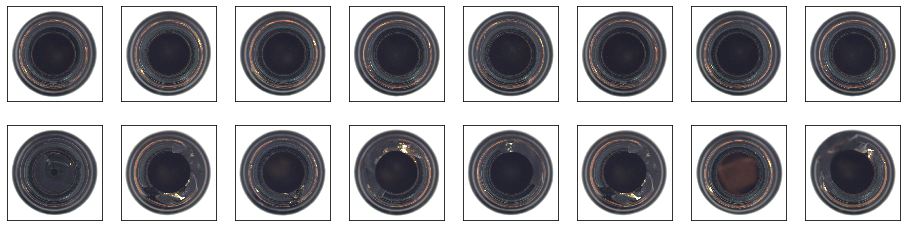

In [13]:
path = os.path.join(img_path, "{}-{}.png".format(NORMAL_STR, ANOMALY_STR))
plot_samples(
    get_images(X_normal_test,8),
    get_images(X_anomaly_test,8),
    plot_mvtec,
    path,
)

# Extracting features with an auto encoder (ae)

In [14]:
def get_codec_from_ae(autoencoder):
    encoder_layer = autoencoder.get_layer("encoder")
    # this model maps an input to its encoded representation; Big image to small rep
    encoder = Model(
        inputs=autoencoder.input, outputs=encoder_layer.output)

    # create a placeholder for an encoded (ENCODING_DIM-dimensional) input
    encoded_input = Input(shape=encoder_layer.output_shape[1:])

    # getting the middle of the autoencoder
    start = (len(autoencoder.layers))//2
    decoder = autoencoder.layers[-start](encoded_input)
    # stacking the decoder layers
    for i in range(start-1, 0, -1):
        decoder = autoencoder.layers[-i](decoder)

    # create the decoder model; "<": encoded(small) representation to big image
    decoder = Model(encoded_input, decoder)
    return encoder, decoder

In [22]:
def build_conv_ae(
    filters, input_shape=(28, 28, 1), kernel=(3, 3), pool_size=(2, 2), color="gray"
):
    # STRETCH GOAL: variable number of layers and pool_size
    pool_size = (2, 2)
    kernel = (3, 3)
    if len(filters) != 4:
        raise ValueError("Four Filters must be given. Sorry.")
    # this is our input placeholder
    input_img = Input(shape=input_shape)
    # layer between input and middle layer
    i = 0
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(input_img)
    encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)
    encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)
    encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)

    # "encoded" is the encoded representation of the input, middle layer of the aue
    encoded = MaxPooling2D(pool_size, padding="same", name="encoder")(encode)

    # layer between middle and output layer
    decode = Conv2DTranspose(filters[i], kernel, activation="relu", padding="same")(encoded)
    decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2DTranspose(filters[i], kernel, activation="relu", padding="same")(decode)
    decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2D(filters[i], kernel, activation="relu")(decode)
    decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2D(filters[i], kernel, activation="relu")(decode)
    decode = UpSampling2D(pool_size)(decode)
    decoded = Conv2D(
        1 if color == "gray" else 3, kernel, activation="sigmoid", padding="same"
    )(decode)

    # this model maps an input to its reconstruction
    autoencoder_single = Model(inputs=input_img, outputs=decoded)
    encoder, decoder = get_codec_from_ae(autoencoder_single)
    autoencoder = multi_gpu_model(autoencoder_single, 4)

    # build (aka "compile") the model
    autoencoder.compile(optimizer="adadelta", loss="mse")
    # autoencoder_single.compile(optimizer="adadelta", loss="mse")
    return autoencoder,autoencoder_single, encoder, decoder

## Training the feature extractor auto encoder

In [23]:
class ModelCkptMultiGPU(Callback):
    """Save the model after every epoch.
    `filepath` can contain named formatting options,
    which will be filled with the values of `epoch` and
    keys in `logs` (passed in `on_epoch_end`).
    For example: if `filepath` is `weights.{epoch:02d}-{val_loss:.2f}.hdf5`,
    then the model checkpoints will be saved with the epoch number and
    the validation loss in the filename.
    # Arguments
        filepath: string, path to save the model file.
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        save_best_only: if `save_best_only=True`,
            the latest best model according to
            the quantity monitored will not be overwritten.
        save_weights_only: if True, then only the model's weights will be
            saved (`model.save_weights(filepath)`), else the full model
            is saved (`model.save(filepath)`).
        mode: one of {auto, min, max}.
            If `save_best_only=True`, the decision
            to overwrite the current save file is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        period: Interval (number of epochs) between checkpoints.
    """

    def __init__(self, filepath,model, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1):
        #super(ModelCheckpoint, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0
        self.model_to_save = model

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('ModelCheckpoint mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch + 1, self.monitor, self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            self.model_to_save.save_weights(filepath, overwrite=True)
                        else:
                            self.model_to_save.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s did not improve from %0.5f' %
                                  (epoch + 1, self.monitor, self.best))
            else:
                if self.verbose > 0:
                    print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
                if self.save_weights_only:
                    self.model_to_save.save_weights(filepath, overwrite=True)
                else:
                    self.model_to_save.save(filepath, overwrite=True)

In [24]:
samples_normal = get_images(X_normal_test,8)


In [ ]:
ckpt_loc = os.path.join(ckpt_path,"feature-extractor-ae3.hdf5")
log_dir = os.path.join(base_log_dir,str(len(os.listdir(base_log_dir))))
if not os.path.isdir(log_dir):
    os.mkdir(log_dir)
    
if os.path.isfile(ckpt_loc):
    print("Loading Autoencoder for %s feature extraction from directory %s..." % (USE_CASE,ckpt_loc))
    ae = load_model(ckpt_loc)
    ae.compile(optimizer="adadelta", loss="mse") # this needs to be compiled since the untrained, single-GPU model is saved instead of the multi-GPU model
    encoder, decoder = get_codec_from_ae(ae)
    # ae.summary()    
else:
    print("Training Autoencoder for %s feature extraction..." % USE_CASE)
    ae,ae_single, encoder, decoder = build_conv_ae(input_shape=samples_normal.shape[1:],filters=[16,12,8,4],color="not-gray")
    earlyStopping = EarlyStopping(
        monitor="val_loss", patience=20, verbose=1, mode="min", min_delta=(1/10**6)
    )
    mcp_save = ModelCkptMultiGPU(
        ckpt_loc, ae_single, save_best_only=True, verbose=1, monitor="val_loss", mode="min"
    )
    
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=5, verbose=1, mode="min"
    )
    tb = TensorBoard(
        log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True
    )
    # ae.summary()   
    ae.fit_generator(
        generator=yield_images(X_normal_train,16),# needs to produce data infinitely
        epochs=256,
        steps_per_epoch=len(X_normal_train),
        shuffle=True,
        validation_data=yield_images(X_normal_validate,16),
        validation_steps=len(X_normal_validate),
        callbacks=[mcp_save,earlyStopping,reduce_lr_loss, tb]
    )

Training Autoencoder for bottle feature extraction...
Epoch 1/256
209/209 [==============================] - 267s 1s/step - loss: 0.0445 - val_loss: 0.0055

Epoch 00001: val_loss improved from inf to 0.00551, saving model to ckpts/bottle/feature-extractor-ae3.hdf5
Epoch 2/256
 44/209 [=====>........................] - ETA: 2:32 - loss: 0.0049

TODO:
 - [x] fix model saving
 - [ ] fix parametrised ae building

## Evaluating the feature extractor

In [73]:
def evaluate_ae(ae, X_train, X_test):
    eval_train = ae.evaluate_generator(yield_images(X_train,4),steps=len(X_train))
    eval_test = ae.evaluate_generator(yield_images(X_test,4),steps=len(X_test))
    return eval_train,  eval_test

In [75]:
eval_train, eval_test = evaluate_ae(
    ae, X_normal_train, X_normal_test
)
print(eval_train, eval_test)

0.0012772320129164454 0.0014441927894949913


In [76]:
encoded_normal_imgs_train = encoder.predict_generator(
    yield_images(X_normal_train, 1, input_only=True), steps=len(X_normal_train)
)  # used later for One Class Classification
encoded_normal_imgs_test = encoder.predict_generator(
    yield_images(X_normal_test, 1, input_only=True), steps=len(X_normal_test)
)
decoded_normal_imgs = decoder.predict(encoded_normal_imgs_test)

In [19]:
decoded_samples_normal = ae.predict(samples_normal)
plot_samples(
   samples_normal,
    decoded_samples_normal,
    plot_mvtec,
    os.path.join(img_path, "rec-{}.png".format(NORMAL_STR)),
)

NameError: name 'ae' is not defined

In [38]:
encoded_anomaly_imgs = encoder.predict_generator(
    yield_images(X_anomaly_test, 1, input_only=True), steps=len(X_anomaly_test)
)  # used later for One Class Classification
print(encoded_anomaly_imgs.shape)

# decode batch wise:
batch_size_decode = 8

epochs = np.arange(0, len(encoded_anomaly_imgs), batch_size_decode)
decoded_anomaly_imgs = np.zeros((0, 900, 900, 3))

for i in range(len(epochs)):
    # print(epochs[i], epochs[i + 1] if i+1<len(epochs) else None)
    decoded_anomaly_imgs = np.concatenate(
        (decoded_anomaly_imgs,
        decoder.predict(encoded_anomaly_imgs[epochs[i] : epochs[i + 1] if i+1<len(epochs) else None]))
    )
len(decoded_anomaly_imgs)

(63, 57, 57, 4)


63

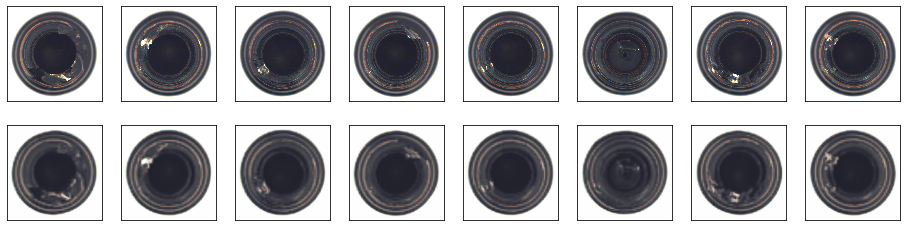

In [44]:
samples_anomaly = get_images(X_anomaly_test,8)
decoded_samples_anomaly = ae.predict(samples_anomaly)

plot_samples(samples_anomaly,
    decoded_samples_anomaly,
    plot_mvtec,
    os.path.join(img_path, "rec-{}.png".format(ANOMALY_STR)),
)

# Anomaly detection
## Loss based
### Computing the reconstruction loss for anomalies and normalities

In [69]:
def loss_per_img(img,rec_img):
    return np.sum(np.power(rec_img - img,2))

In [70]:
normal_losses = np.array([loss_per_img(i, ri) for i, ri in zip(samples_normal,decoded_samples_normal) ])
anomaly_losses = np.array([loss_per_img(i, ri)for i, ri in zip(samples_anomaly, decoded_samples_anomaly)])
normal_losses.mean(), anomaly_losses.mean()

(3473.4546158686007, 3710.268900859317)

In [47]:
def plot_hist(values, bins=50, relative=False, color="r"):
    t = np.linspace(values.min(), values.max(), bins)
    denominator = len(values) if relative else 1
    hist = np.histogram(values, bins)
    plt.plot(t, hist[0]/denominator, color)

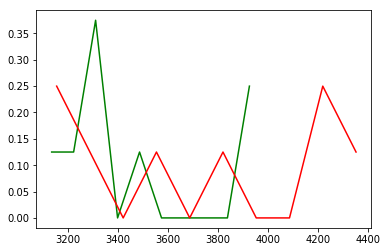

In [48]:
bins = 10
# loss distribution over the normal dataset
plot_hist(normal_losses,relative=True,color="g",bins=bins)
# loss distribution over the anomaly dataset 
plot_hist(anomaly_losses,relative=True,color="r",bins=bins)
plt.show()

### Evaluating the loss based approach

8

threshold:0.000,dn:1.000000 + ua:0.000000 = 0.500000

threshold:0.050,dn:1.000000 + ua:0.000000 = 0.500000

threshold:0.100,dn:1.000000 + ua:0.000000 = 0.500000

threshold:0.150,dn:0.875000 + ua:0.250000 = 0.562500

threshold:0.200,dn:0.875000 + ua:0.250000 = 0.562500

threshold:0.250,dn:0.750000 + ua:0.375000 = 0.562500

threshold:0.300,dn:0.750000 + ua:0.375000 = 0.562500

threshold:0.350,dn:0.750000 + ua:0.375000 = 0.562500

threshold:0.400,dn:0.625000 + ua:0.375000 = 0.500000

threshold:0.450,dn:0.625000 + ua:0.375000 = 0.500000

threshold:0.500,dn:0.500000 + ua:0.375000 = 0.437500

threshold:0.550,dn:0.500000 + ua:0.375000 = 0.437500

threshold:0.600,dn:0.500000 + ua:0.375000 = 0.437500

threshold:0.650,dn:0.375000 + ua:0.375000 = 0.375000

threshold:0.700,dn:0.375000 + ua:0.375000 = 0.375000

threshold:0.750,dn:0.250000 + ua:0.625000 = 0.437500

threshold:0.800,dn:0.250000 + ua:0.625000 = 0.437500

threshold:0.850,dn:0.250000 + ua:0.625000 = 0.437500

threshold:0.900,dn:0.1250

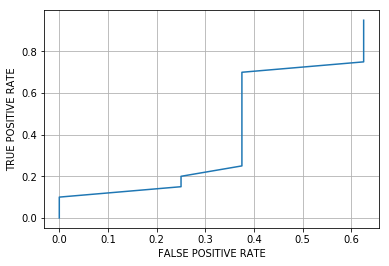

(0.9500000000000001, 3926.008118367043)

In [53]:
# x:= "false detected anomalies in %"
# y:= "correct detected normal data points in %"
FPs = FNs = []
prec = 20  # precision for getting the best threshold value
step_size = 1.0 / prec
TPs = np.arange(0, 1, step_size)

sorted_losses = np.sort(normal_losses)
print(len(sorted_losses))
for i in TPs:
    # loss value for detection of i*100 percent normal data points
    loss_boundary = sorted_losses[int(len(normal_losses) * i)]
    print()
    detected_normals = samples_normal[normal_losses >= loss_boundary]
    undetected_anomalies = samples_anomaly[anomaly_losses < loss_boundary]

    FP_rate = len(undetected_anomalies) / len(
        anomaly_losses
    )  # ratio between not detected loss values for anomalies
    FN_rate = len(detected_normals) / len(
        normal_losses
    )  # ratio between not detected loss values for anomalies

    FPs = np.append(FPs, FP_rate)  # not detected anomalies
    FNs = np.append(FNs, FN_rate)  # as anomalies detected normalities
    if (FP_rate + FN_rate)/2 <= min(
        (FNs + FPs)/2
    ):  # less or equal since we want the biggest TP_rate (i)
        loss_threshold = i
        best_boundary = loss_boundary

    # print every 1/10 threshold step
    if (int(i * prec)) % (prec // 20) == 0:
        print(
            "threshold:%.3f,dn:%f + ua:%f = %f"
            % (i, FN_rate, FP_rate, (FN_rate + FP_rate)/2)
        )
    # minimum value for FN_rate + FP_rate (least relative amount of falsely detected)

plt.plot(FPs, TPs)
plt.grid()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.show()
loss_threshold, best_boundary

In [55]:
detected_normals =samples_normal[normal_losses >= best_boundary]  # values on the boundary are seen as anomalies
undetected_anomalies =samples_anomaly[anomaly_losses < best_boundary]
len(detected_normals), len(undetected_anomalies)

(1, 5)

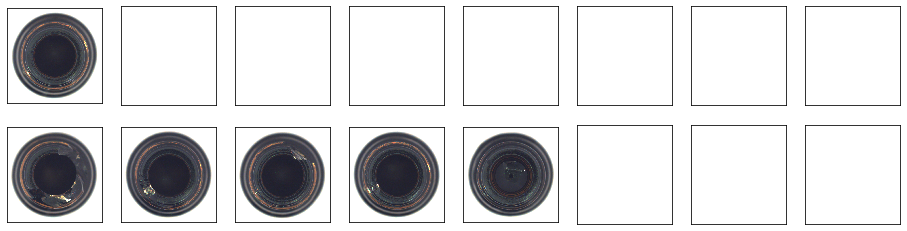

In [56]:
plot_samples(detected_normals,undetected_anomalies,plot_mvtec, os.path.join(img_path,"wrong-{}.png".format(USE_CASE)))

### Predicting with the reconstruction loss approach

In [60]:
def is_anomaly(X,boundary):
    rec_img = ae.predict(X.reshape(1,900,900,3))
    #plot_mvtec(rec_img.reshape(900,900,3))
    #plt.show()
    # print(X)
    loss =  loss_per_img(rec_img,X)
    print(loss)
    return loss > boundary

In [61]:
this_should_be_false = is_anomaly(normal_test_imgs[-1], best_boundary)
this_should_be_true = is_anomaly(anomaly_test_imgs[-1], best_boundary)
this_should_be_false, this_should_be_true

3594.2141142861083
5475.89855015775


(False, True)

## One Class SVM approach

In [62]:
from sklearn import svm
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score,accuracy_score

In [68]:
encoded_normal_imgs_train = encoded_normal_imgs_train.reshape(
            -1, np.prod(encoded_normal_imgs_train.shape[1:])
        )
encoded_normal_imgs_test = encoded_normal_imgs_test.reshape(
            -1, np.prod(encoded_normal_imgs_test.shape[1:])
        )
encoded_anomaly_imgs = encoded_anomaly_imgs.reshape(-1, np.prod(encoded_anomaly_imgs.shape[1:]))
best_metrics =0,0,0
for i in np.arange(0.1, 1, 0.1):
    clf = svm.OneClassSVM(gamma="auto", nu=i)
    clf.fit(encoded_normal_imgs_train)
    
    score_normal = clf.predict(encoded_normal_imgs_test)
    bins = 2
    # hist_normal = np.histogram(score_normal, bins)
    # t = np.linspace(score_normal.min(), score_normal.max(), bins)
    # plt.bar(t, hist_normal[0], width=0.5, color="g")
    # plt.show()

    score_anomaly = clf.predict(encoded_anomaly_imgs)

    # hist_anomaly = np.histogram(score_anomaly, bins)
    # t = np.linspace(score_anomaly.min(), score_anomaly.max(), bins)
    # plt.bar(t, hist_anomaly[0], width=0.5, color="r")
    # plt.show()


    TP = len(score_normal[score_normal == 1])
    FN = len(score_normal[score_normal == -1])

    TN = len(score_anomaly[score_anomaly == -1])
    FP = len(score_anomaly[score_anomaly == 1])
    accuracy = (TP + TN) / (len(score_normal) + len(score_anomaly))
    precision = TP / (TP + FN)
    recall = TP / (TP + FP)
    if (accuracy,precision,recall) > best_metrics:
        best_nu = i
        best_metrics = accuracy,precision,recall
        oc_svm = clf
    print("%.2f" % i, accuracy, precision, recall)
best_nu,best_metrics

0.10 0.8313253012048193 0.7 0.6363636363636364
0.20 0.8795180722891566 0.7 0.7777777777777778
0.30 0.8554216867469879 0.5 0.8333333333333334
0.40 0.7831325301204819 0.15 0.75
0.50 0.7710843373493976 0.1 0.6666666666666666
0.60 0.7710843373493976 0.1 0.6666666666666666
0.70 0.7831325301204819 0.1 1.0
0.80 0.7831325301204819 0.1 1.0
0.90 0.7710843373493976 0.05 1.0


(0.2, (0.8795180722891566, 0.7, 0.7777777777777778))

In [64]:
def is_anomaly_svm(X,oc_svm):
    X = X.reshape((1,X.shape[0]))
    prediction = oc_svm.predict(X)[0]
    return prediction == -1

In [65]:
this_should_be_false_svm = is_anomaly_svm(encoded_normal_imgs_train[0], oc_svm)
this_should_be_true_svm = is_anomaly_svm(encoded_anomaly_imgs[0], oc_svm)
this_should_be_false_svm, this_should_be_true_svm

(False, True)

# TODO: Encoded feature analysis with our friend CF Gauss

In [146]:
flat_shape = np.prod(encoded_normal_imgs_train.shape[1:], dtype=np.int64)
encoded_normal_imgs_train = encoded_normal_imgs_train.reshape(
    len(encoded_normal_imgs_train), flat_shape
)
encoded_normal_imgs_test = encoded_normal_imgs_test.reshape(
    len(encoded_normal_imgs_test), flat_shape
)

In [147]:
def gauss(x_i, my_i, sigma_i2):
    # gaussian distribution for one feature
    if sigma_i2 == 0:
        return 1 if x_i == my_i else 0
    return np.array(
        (1 / np.sqrt(2 * np.pi * sigma_i2))
        * np.exp(-(x_i - my_i) ** 2 / (2 * sigma_i2))
    )

In [148]:
def my(X):
    return np.array([(1 / len(x)) * np.sum(x) for x in X.T])

In [149]:
def sigma2(X, my):
    # computes sigma squared for each feature
    m = len(X)  # number of data points
    return np.array([(1/m)*np.sum((X[:, i] - my[i]) ** 2) for i in range(len(my))])

In [150]:
def p(X,my,sigma2):
    return np.array([np.prod([gauss(x[i], my[i], sigma2[i])
               for i in range(len(x))]) for x in X])

In [156]:
X= encoded_normal_imgs_test
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = p(X, my, sigma_2)
my

array([1.99189777, 0.        , 2.20821114, ..., 0.53145118, 1.85000763,
       0.30248611])

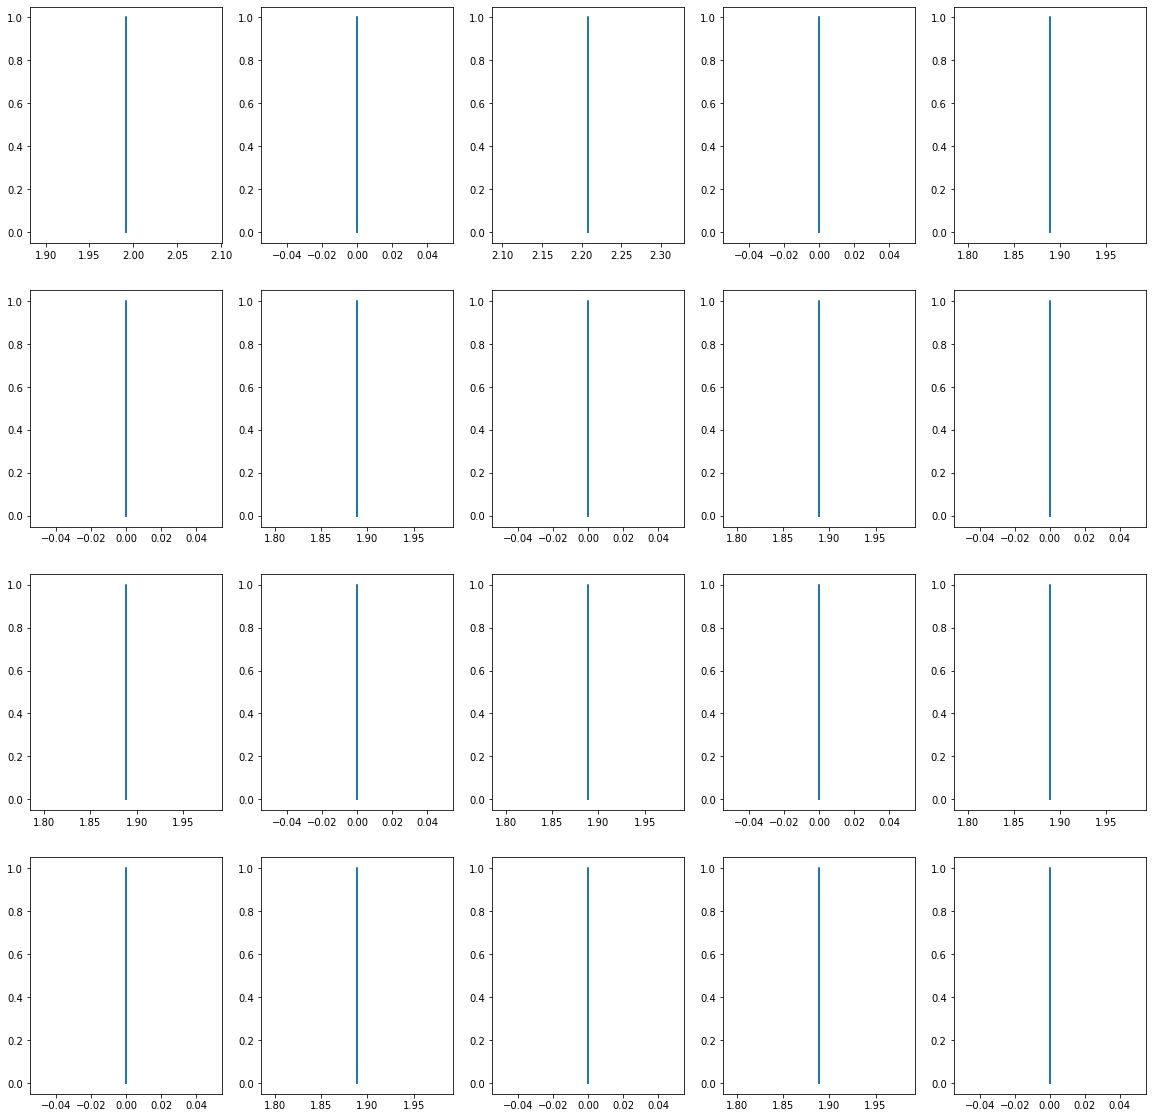

In [158]:
plt.figure(figsize=(20, 20))
for i in range(20):
    # plots distribution of i-th feature
    # display original
    bins = 20
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 5, i + 1)
    r = np.linspace(start=min(X[:, i]), stop=max(X[:, i]), num=bins)
    plt.plot(r, hist[0]/len(X[:,i]))

In [ ]:
X= encoded_anomaly_imgs
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = p(X, my, sigma_2)
plt.figure(figsize=(20, 20))
for i in range(len(my)-1):
    # plots distribution of i-th feature
    # display original
    bins = 20
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 6, i + 1)
    r = np.linspace(start=min(X[:, i]), stop=max(X[:, i]), num=bins)
    plt.plot(r, hist[0]/len(X[:,i]))